# Tutorial 3: Multitaper-Welch SPOD 
In this tutorial, we use the same dataset as tutorial2 but use a different way - multitaper-Welch method - to estimate the spenctrum.

## Import required libraries

In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Current, parent and file paths
CWD = os.getcwd()
CFD = os.path.abspath('')

# project libraries
sys.path.append(os.path.join(CFD,"../../"))

# Import library specific modules
from pyspod.spod.standard  import Standard  as spod_standard # for use of multitaper method
from pyspod.spod.multitaper  import Standard  as spod_multitaper # for use of multitaper method
import pyspod.spod.utils     as utils_spod
import pyspod.utils.weights  as utils_weights
import pyspod.utils.errors   as utils_errors
import pyspod.utils.io       as utils_io
import pyspod.utils.postproc as post

## Read data and parameters
The multitaper-Welch method can be activated by setting the parameter require
We use same configuration as tutorial 2, but set the additional parameters
```yaml
Required:
half_bandwidth = 5.5   # bandwidth

Optional:
n_tapers = 10  # number of tapers
```
In detail, the parameters are:
- `half_bandwidth`,the multiply of fft number and spectral energy concentration half bandwidth, indicate resolution
- `n_tapers`, the number of tapers(windows) used for each block. By default, `n_taper` = 2*`half_bandwidth`-1 [1].

[1] [Oliver T. Schmidt, 2023](https://link.springer.com/article/10.1007/s00162-022-00626-x)

In [7]:
## -------------------------------------------------------------------
## read data and params
## -------------------------------------------------------------------
## data
data_file = os.path.join(CFD, '../../tests/data/', 'era_interim_data.nc')
ds = utils_io.read_data(data_file=data_file)
print(ds)
## we extract time, longitude and latitude
t = np.array(ds['time'])
x1 = np.array(ds['longitude']) - 180
x2 = np.array(ds['latitude'])
data = ds['tp']
nt = len(t)
print('shape of t (time): ', t.shape)
print('shape of x1 (longitude): ', x1.shape)
print('shape of x2 (latitude) : ', x2.shape)
## params
config_file = os.path.join(CFD, '../../tests/data', 'input_tutorial2.yaml')
params = utils_io.read_config(config_file)
## set weights
weights = utils_weights.geo_trapz_2D(
    x1_dim=x2.shape[0], x2_dim=x1.shape[0],
    n_vars=params['n_variables'])
## -------------------------------------------------------------------

<xarray.Dataset>
Dimensions:    (longitude: 80, latitude: 41, time: 7305)
Coordinates:
  * longitude  (longitude) float32 0.0 4.5 9.0 13.5 ... 342.0 346.5 351.0 355.5
  * latitude   (latitude) float32 90.0 85.5 81.0 76.5 ... -81.0 -85.5 -90.0
  * time       (time) datetime64[ns] 2008-01-01T03:00:00 ... 2017-12-31T03:00:00
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-07-13 13:05:17 GMT by grib_to_netcdf-2.22.0: grib_to_n...
shape of t (time):  (7305,)
shape of x1 (longitude):  (80,)
shape of x2 (latitude) :  (41,)


## Welch's method

 
Initialize data ...
 
Initialize data
------------------------------------
- reading first time snapshot for data dimensions
- getting data dimensions
- checking weight dimensions
- distributing data (if parallel)
- loaded data into memory: 0.0 s.
- computed mean: 0.004984140396118164 s.
SPOD parameters
------------------------------------
Problem size (real)      : 0.08925944566726698 GB.
Problem size (complex)   : 0.17851889133453397 GB.
Data type for real       : <class 'numpy.float32'>
Data type for complex    : <class 'numpy.complex64'>
No. snapshots per block  : 730
Block overlap            : 0
No. of blocks            : 10
Windowing fct. (time)    : hamming
Weighting fct. (space)   : geo_trapz_2D
Mean                     : longtime
Number of frequencies    : 366
Time-step                : 12
Time snapshots           : 7305
Space dimensions         : 2
Number of variables      : 1
Normalization weights    : False
Normalization data       : False
No. modes to be saved    : 10
Co

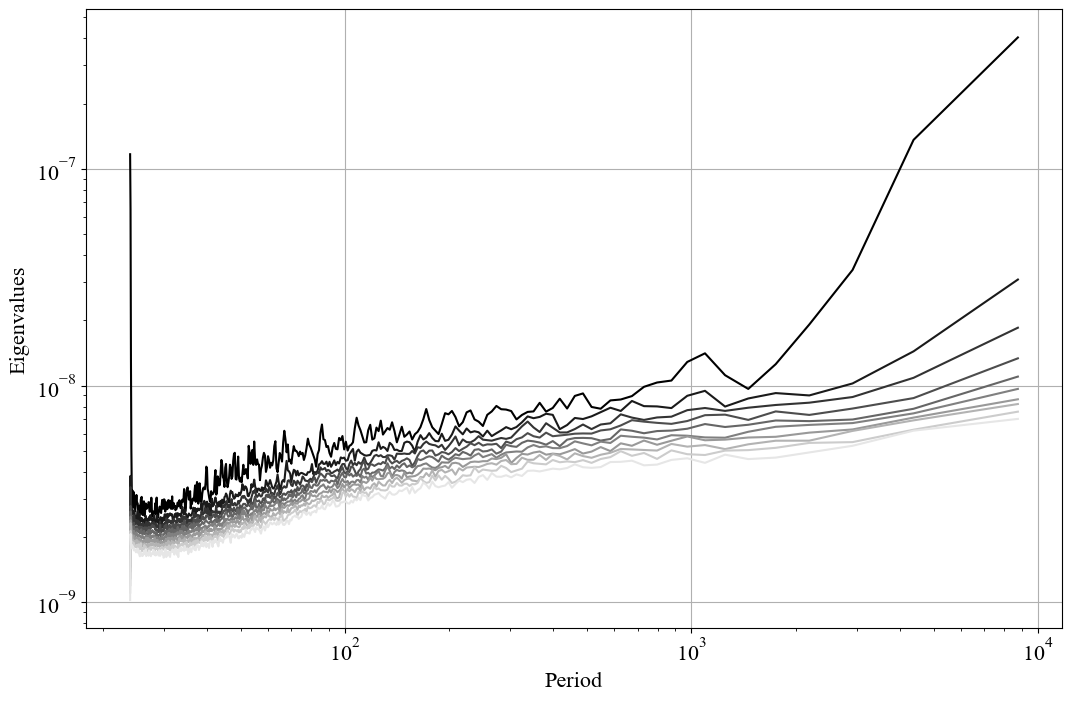

In [8]:
## -------------------------------------------------------------------
## compute spod using Welch's method
## -------------------------------------------------------------------
standard  = spod_standard(params=params, weights=weights)
spod_stad = standard.fit(data_list=data)
standard_results_dir = spod_stad.savedir_sim
spod_stad.plot_eigs_vs_period()
## -------------------------------------------------------------------

# Multitaper-Welch method
Here for simplicity we keep other settings same as the Welch's method. In practice, however, the number of blocks, number of dft points, and number of tapers can be flexiably adjusted to reach a trade-off between resolution, bias and variance.

 
Initialize data ...
 
Initialize data
------------------------------------
- reading first time snapshot for data dimensions
- getting data dimensions
- checking weight dimensions
- distributing data (if parallel)
- loaded data into memory: 0.0 s.
- computed mean: 0.003989458084106445 s.
SPOD parameters
------------------------------------
Problem size (real)      : 0.08925944566726698 GB.
Problem size (complex)   : 0.17851889133453397 GB.
Data type for real       : <class 'numpy.float32'>
Data type for complex    : <class 'numpy.complex64'>
No. snapshots per block  : 730
Block overlap            : 0
No. of blocks            : 10
Windowing fct. (time)    : Slepsec
Weighting fct. (space)   : geo_trapz_2D
Mean                     : longtime
Number of frequencies    : 366
Time-step                : 12.0
Time snapshots           : 7305
Space dimensions         : 2
Number of variables      : 1
Normalization weights    : False
Normalization data       : False
No. modes to be saved    : 10


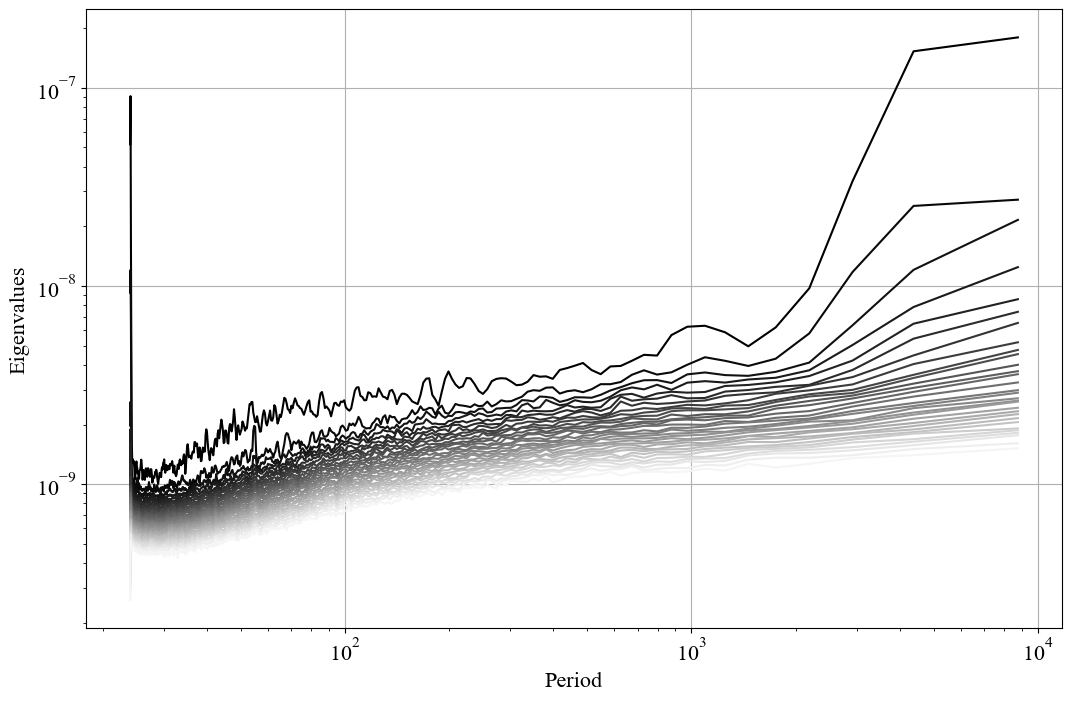

In [18]:
params['half_bandwidth'] = 2   # by default it will set n_taper = 10
# params['n_tapers'] = 3  # number of tapers can also be customized, larger tapers reduces variance
multitaper = spod_multitaper(params=params, weights=weights)
spod_mltp = multitaper.fit(data_list=data)
multitaper_results_dir = spod_mltp.savedir_sim
spod_mltp.plot_eigs_vs_period()

## SPOD mode comparison

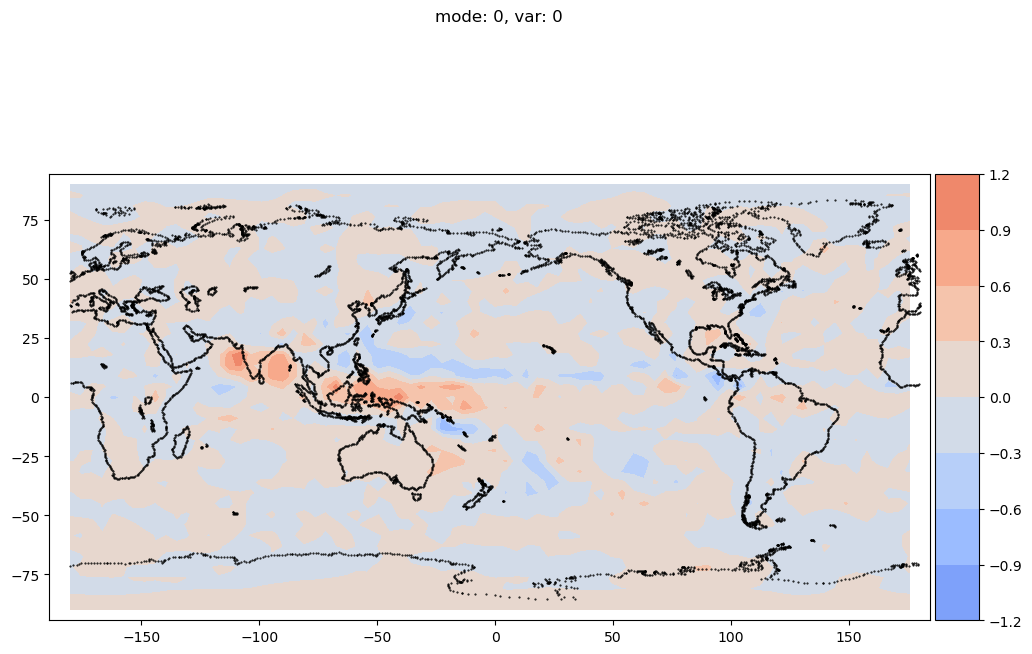

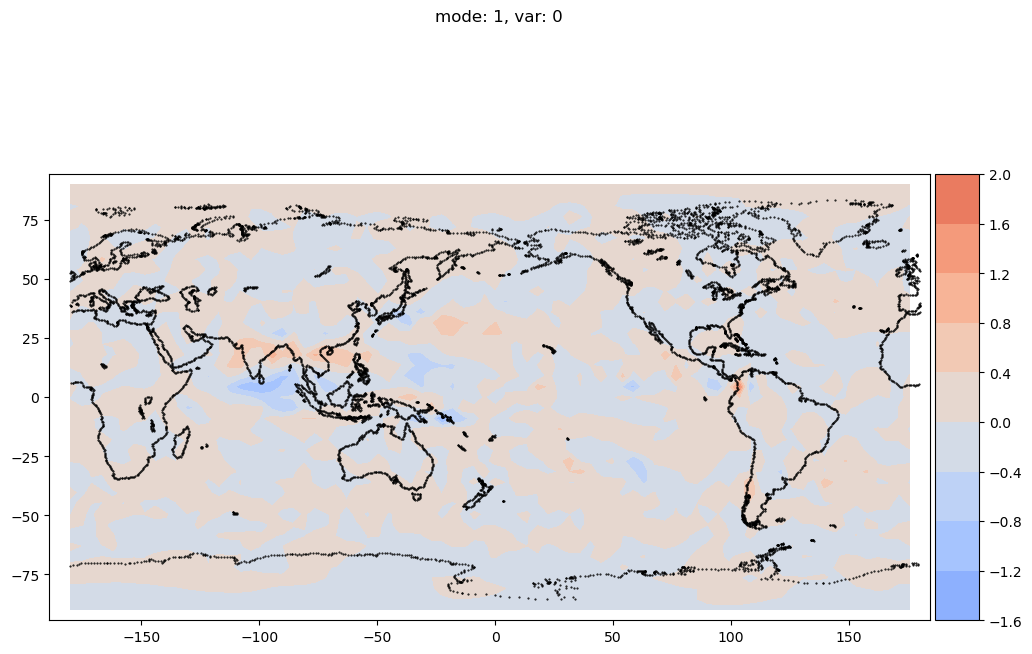

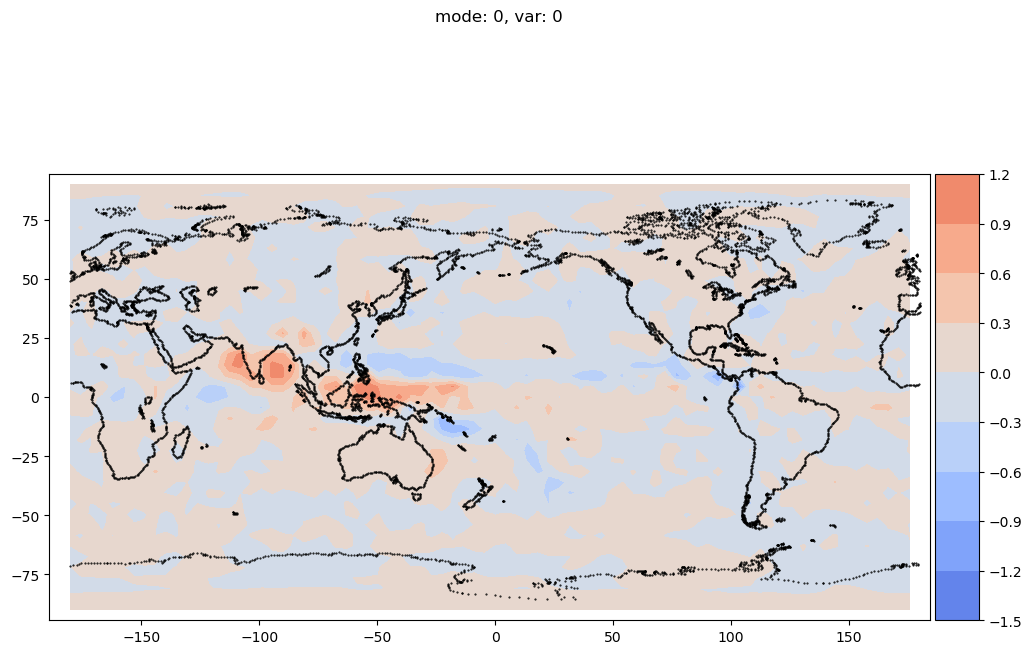

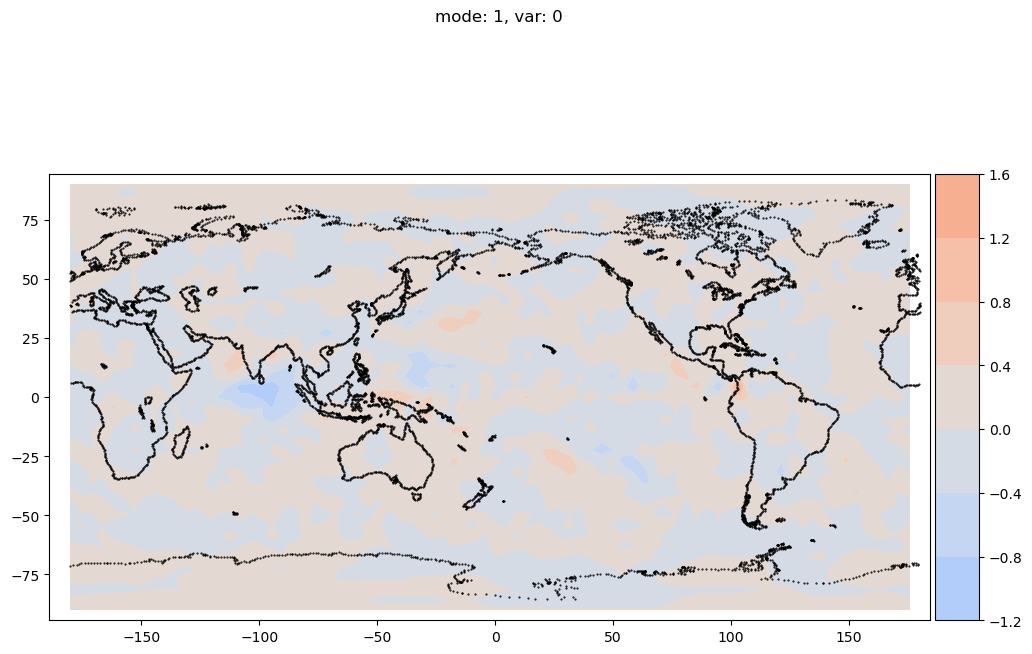

In [23]:
T = 1008 # hours, typical for MJO

f_stad, f_stad_idx = spod_stad.find_nearest_freq(freq_req=1/T, freq=spod_stad.freq)
spod_stad.plot_2d_modes_at_frequency(freq_req=f_stad, freq=spod_stad.freq,
    modes_idx=[0,1], x1=x1, x2=x2, coastlines='centred',
    equal_axes=True)

f_mltp, f_mltp_idx = spod_mltp.find_nearest_freq(freq_req=1/T, freq=spod_mltp.freq)
spod_mltp.plot_2d_modes_at_frequency(freq_req=f_mltp, freq=spod_mltp.freq,
    modes_idx=[0,1], x1=x1, x2=x2, coastlines='centred',
    equal_axes=True)
